###### Inicialização

In [1]:
!pip install meteostat yfinance missingno


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)
import plotly.graph_objects as go

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Análise de Séries temporais (Sessão 9)
---
Pré-processamento (parte 6)

## Auto correlação

Uma importante característica de uma série temporal é a sua correlação serial.

1) A autocorrelação é uma adimensional da associação linear entre duas variáveis aleatórias

\begin{align}
p(h) = Cor(X_t,X_{t-h}) = \frac{Cov(X_t,X_{t-h})}{\sqrt{Var(X_t)Var(X_{t-h})}}
\end{align}

- A autocorrelação depende apenas do intervalo entre as medidas (h).
- Um valor de autocorrelação para um certo h é chamado de Coeficiente de Correlação (de Pearson).
- A autocorrelação varia entre -1 e 1 para uma perfeita correlação linear negativa e positiva, respectivamente.
- Uma autocorrelação igual à ZERO significa nenhuma correlação ou seja as variáveis são independentes!


#### Construindo e obtendo os dados

Construindo os dados sintéticos

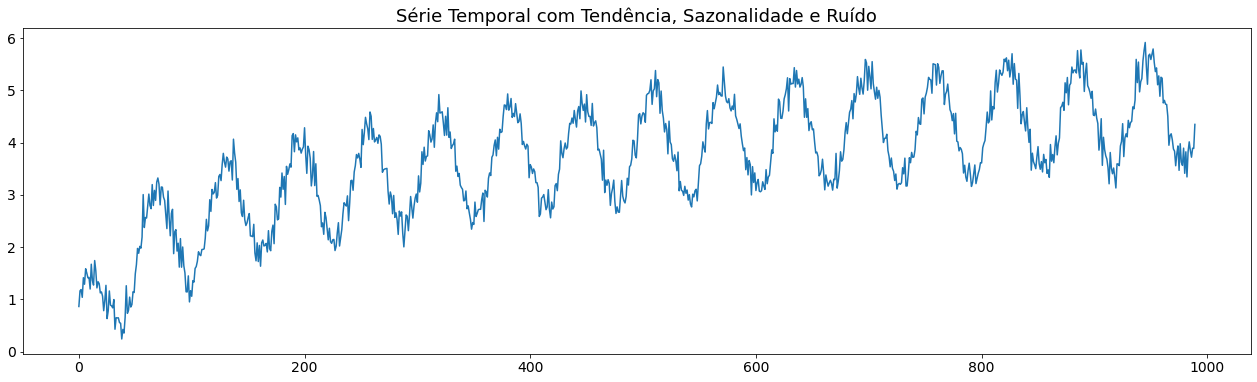

In [4]:
x = np.arange(1, 100, 0.1)
T = pd.Series(np.log(x))

S = pd.Series(np.sin(x))

mu, sigma = 0, .2
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)

X = T + S + R
_ = X.plot(kind='line', title="Série Temporal com Tendência, Sazonalidade e Ruído")

In [5]:
n = len(X)
c0 = ((X - X.mean()) ** 2).sum()
plugin = lambda h : ((X[:n - h] - X.mean()).values * (X[h:] - X.mean()).values).sum() / c0

autocorr_sinteticos = [plugin(loc) for loc in (np.arange(n) + 1)]

Obtendo os dados de temperatura de Aracaju

In [6]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [7]:
X1 = serie_aracaju.tavg

n = len(X1)
c0 = ((X1 - X1.mean()) ** 2).sum()
rho = lambda h : ((X1[:n - h] - X1.mean()).values * (X1[h:] - X1.mean()).values).sum() / c0

autocorr_temp = [rho(loc) for loc in (np.arange(n) + 1)]

### Adtivos ao Correlograma

#### Horizonte máximo

Geralmente, não existe a necessidade (ou não é recomendado), calcular todos os horizontes na função de autocorrelação. Existem alguns limitadores comuns para esta análise, como:

\begin{align}
h_{máximo} = 10 \log_{10}(N)
\end{align}
<center>ou</center>
\begin{align}
h_{máximo} = \frac{N}{4}
\end{align}

In [8]:
h_max1, hmax2 = 10*np.log10(len(X)), len(X)/4
h_max1, hmax2

(29.9563519459755, 247.5)

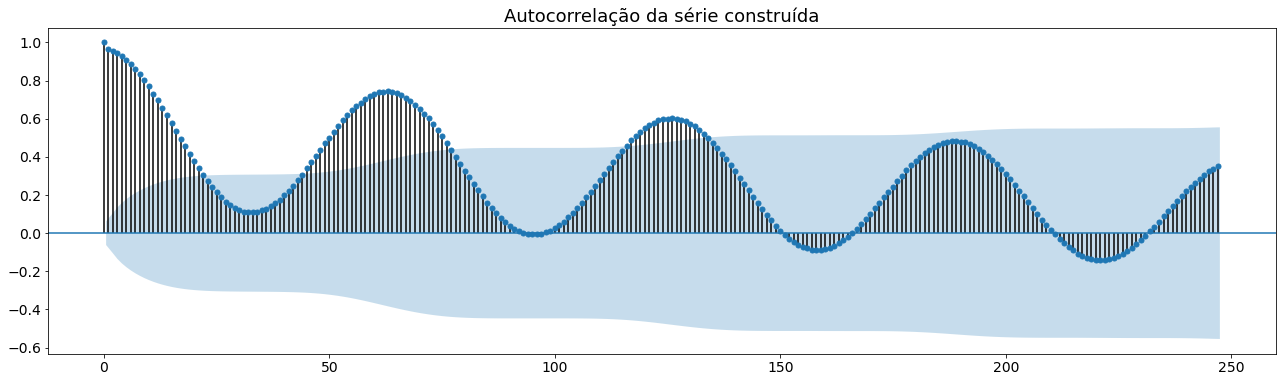

In [9]:
_ = tsa.plot_acf(X, lags=len(X)/4, title="Autocorrelação da série construída")

In [10]:
10*np.log10(len(serie_aracaju.tavg)), len(serie_aracaju.tavg)/4

(32.46744709723841, 441.25)

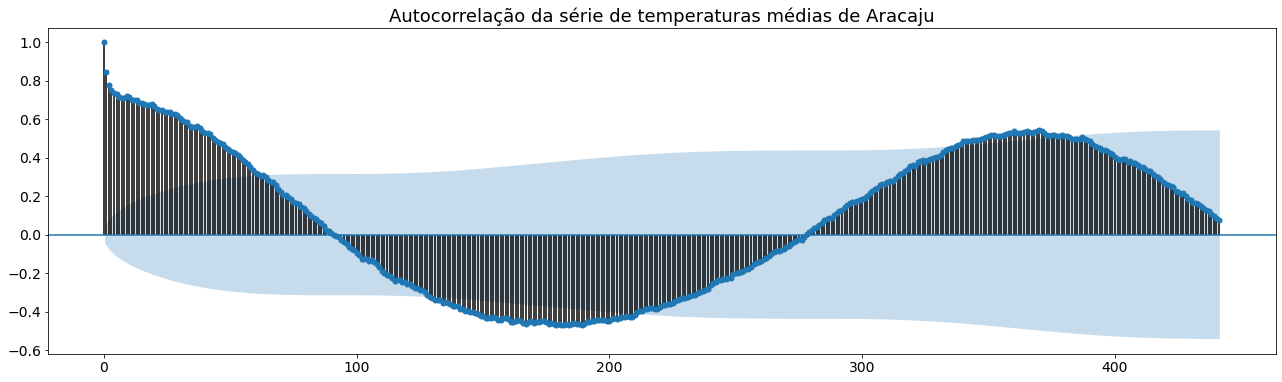

In [13]:
_ = tsa.plot_acf(serie_aracaju.tavg, lags=len(serie_aracaju.tavg)/4, title="Autocorrelação da série de temperaturas médias de Aracaju")

#### Intervalo de confiança

Para qualquer série temporal estacionária, os coeficientes da função de autocorrelação $\rho(h)$ que caírem no intervalo de confiança, serão **considerados ZERO com 95% de probabilidade**, enquanto que aqueles coeficientes que caírem fora do intervalo, serão considerados **diferentes de ZERO**.

\begin{align}
intervalo = \frac{±1,96}{\sqrt N}
\end{align}

In [ ]:
z95 = stats.norm.ppf(1 - 0.05 / 2.0) #1.959963984540054
- (z95 / np.sqrt(len(X))), z95 / np.sqrt(len(X))

Fator de ajuste de dois erros padrões médios de cada retorno da FAC:

\begin{align}
intevalo = ± \space ppf(1- \frac{\alpha}{2}) * \sqrt{2*\frac{\sum_{h=2}^H({\rho(h)^2})}{H}+ 1}
\end{align}

In [ ]:
_alpha = 0.05
fac = np.array(autocorr_temp)

varacf = np.ones_like(autocorr_temp) / len(X1)
varacf[0] = 0
varacf[1] = 1.0 / len(X1)
varacf[2:] *= 1 + 2 * np.cumsum(fac[1:-1] ** 2)

intervalo = stats.norm.ppf(1 - _alpha / 2.0) * np.sqrt(varacf)

_ = pd.DataFrame(np.array((-intervalo, intervalo)).T).plot(title="Intervalo de confiânça utilizado pelo statsmodels", ylim=(-1,1))

#### Teste de Ljung-Box

Este teste avalia se existe autocorrelação significante na série temporal. O teste estatístico é escrito como:
\begin{align}
Q(k) = N*(N+2)\sum_{h=1}^k{\frac{\rho(h)^2}{N-h}}
\end{align}
Onde:
- $N$ é comprimento da série temporal
- $\rho(h)$ é o coeficiente de correlação em $h$
- $k$ é o intervalo máximo que o teste é realizado

O teste estatístico segue assintoticamente uma distribuição Qui-quadrado $x^2$ com $k$ graus de liberdade.

Seguindo com o teste:
- $H_0$ - Nossa hipótese nula - O Resíduo é independentemente distribuído.
- $H_1$ - Nossa hipótese alternativa - Os resíduos não são independentemente distribuídos e exibem uma correlação serial.

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def resultado_ljungbox(resultado, alpha = 0.05):
  rejeita = "O resíduo não parece independentemente distribuído (rejeitamos H0)"
  falha = "O resíduo parece independentemente distribuído (falhamos em rejeitar H0)"
  resultado["rejeita_h0"] = resultado["lb_pvalue"] < alpha
  resultado["conclusão"] = resultado["rejeita_h0"].apply(lambda x : rejeita if x else falha)
  return resultado

**Aplicando o teste na série de dados sintéticos**


In [15]:
resultado_ljungbox( acorr_ljungbox(X, lags=np.arange(1,5), return_df=True) )

,lb_stat,lb_pvalue,rejeita_h0,conclusão
1,926.945630,1.362259e-203,True,O resíduo não parece independentemente distrib...
2,1837.220454,0.000000e+00,True,O resíduo não parece independentemente distrib...
3,2726.551033,0.000000e+00,True,O resíduo não parece independentemente distrib...
4,3587.589132,0.000000e+00,True,O resíduo não parece independentemente distrib...


**Aplicando o teste na série de ruído gerada**

In [16]:
resultado_ljungbox( acorr_ljungbox(R, lags=np.arange(1,5), return_df=True) )

,lb_stat,lb_pvalue,rejeita_h0,conclusão
1,0.968401,0.325079,False,O resíduo parece independentemente distribuído...
2,0.968415,0.616185,False,O resíduo parece independentemente distribuído...
3,1.263232,0.737882,False,O resíduo parece independentemente distribuído...
4,2.332341,0.674887,False,O resíduo parece independentemente distribuído...


**Aplicando o teste na série de temperatura de Aracaju**

In [17]:
resultado_ljungbox( acorr_ljungbox(X1, lags=np.arange(1,5), return_df=True) )

,lb_stat,lb_pvalue,rejeita_h0,conclusão
1,1262.728544,1.422075e-276,True,O resíduo não parece independentemente distrib...
2,2335.860551,0.000000e+00,True,O resíduo não parece independentemente distrib...
3,3338.203495,0.000000e+00,True,O resíduo não parece independentemente distrib...
4,4303.804062,0.000000e+00,True,O resíduo não parece independentemente distrib...


**Aplicando o teste nos resíduos extraídos da série de temperatura de Aracaju**


In [18]:
result_temp = sm.tsa.seasonal_decompose(X1, model='additive', period=365)
resultado_ljungbox( acorr_ljungbox(result_temp.resid.dropna(), lags=np.arange(1,5), return_df=True) )

,lb_stat,lb_pvalue,rejeita_h0,conclusão
1,333.556571,1.615005e-74,True,O resíduo não parece independentemente distrib...
2,457.279037,5.047994e-100,True,O resíduo não parece independentemente distrib...
3,523.856319,3.224175e-113,True,O resíduo não parece independentemente distrib...
4,549.362041,1.405903e-117,True,O resíduo não parece independentemente distrib...


#### Efeito de compensação

Pode ser demostrado matematicamente que:

\begin{align}
\sum_{k=1}^{N-1}{\rho(k)} = -\frac{1}{2}
\end{align}

Assim, essa condição levará inevitavelmente a ocorrência de artefatos, ou seja, correlações negativas.

Esse efeito é mais forte quando o processo da série temporal tiver apenas correlações positivas. Porque a condição acima levará a "produção" de correlações negativas.

Atenção: esses artefatos podem até mesmo exceder os limites do intervalo de confiança.

In [19]:
np.sum(autocorr_sinteticos), np.sum(autocorr_temp)

(-0.4999999999999858, -0.5000000000000036)

O que fazer? Limitar o $h_{máximo}$ para apenas os primeiros intervalos da função de autocorrelação.

In [20]:
np.sum(autocorr_sinteticos[:int(10*np.log10(len(X)))]), np.sum(autocorr_temp[:int(10*np.log10(len(X1)))])

(16.420446951072826, 21.801188576595337)

## Autocorrelação Parcial

Uma autocorrelação parcial é um resumo da relação entre uma observação em uma série temporal com observações em etapas de tempo anteriores com as relações de observações intervenientes removidas.

A autocorrelação parcial no lag k é a correlação que resulta após a remoção do efeito de quaisquer correlações devido aos termos em lags mais curtos.

A autocorrelação para uma observação e uma observação em uma etapa de tempo anterior é composta tanto pela correlação direta quanto pelas correlações indiretas. Essas correlações indiretas são uma função linear da correlação da observação, com observações em intervalos de tempo intervenientes.

São essas correlações indiretas que a função de autocorrelação parcial procura remover.

<center>

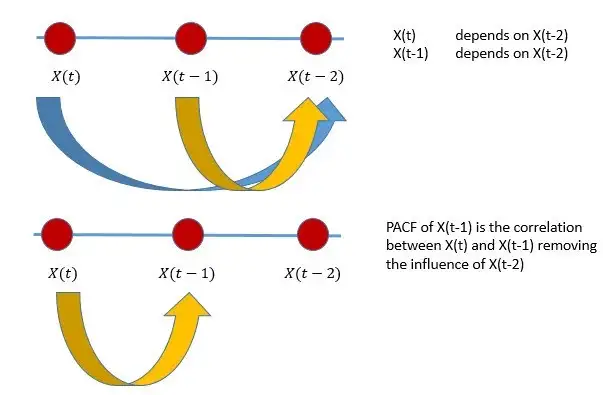

Imagem 1 — Explicação da autocorrelação parcial (fonte: [Analytics Vidhya](https://medium.com/analytics-vidhya/5-steps-to-get-an-understanding-on-correlation-auto-correlation-and-partial-auto-correlation-e71f6b4bba81))
</center>




Sendo assim, podemos definir a autocorrelação parcial através da equação:

\begin{align}
 \pi(h) &= Cor(X_t,X_{t-h} | X_{t-1}, ..., X_{t-h+1}) \\[1em]
 \pi(h) &= \frac{Cov([X_t|X_{i-1},X_{i-2},...,X_{i-h+1}],[X_{t-h}|X_{i-1},X_{i-2},...,X_{i-h+1}]}{\sqrt{Var([X_t|X_{i-1},X_{i-2},...,X_{i-h+1}] \cdot Var([X_{t-h}|X_{i-1},X_{i-2},...,X_{i-h+1}])}}
\end{align}

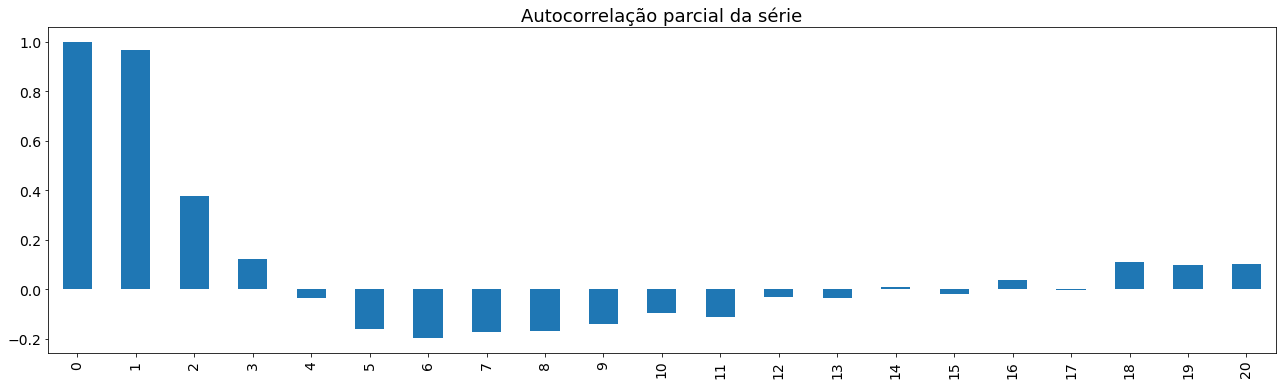

In [21]:
from statsmodels.tsa.tsatools import lagmat

nlags = 20
X_ = X - np.mean(X)
pacf = np.empty(nlags + 1)
pacf[0] = 1.0

xlags, x0 = lagmat(X_, nlags, original="sep", trim="both")
for k in range(1, nlags + 1):
    params = np.linalg.lstsq(xlags[:, :k], x0, rcond=None)[0]
    pacf[k] = params[-1]

_ = pd.Series(pacf).plot(kind="bar", title="Autocorrelação parcial da série")

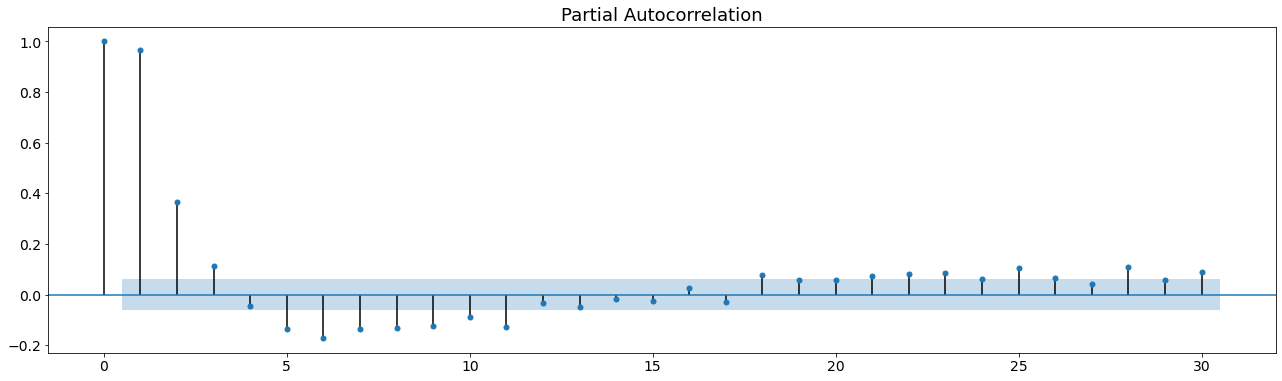

In [22]:
_ = tsa.plot_pacf(X)

### Comportamentos para cada tipo de série

1. Sazonal + Ruído (Sem tendência)

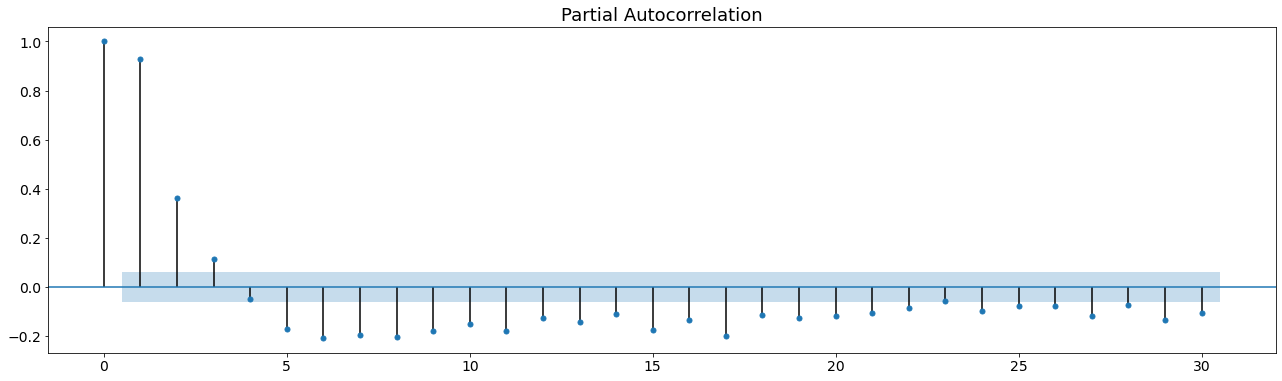

In [26]:
_ = tsa.plot_pacf(S+R)

1. Tendência + Ruído (Sem tendência)

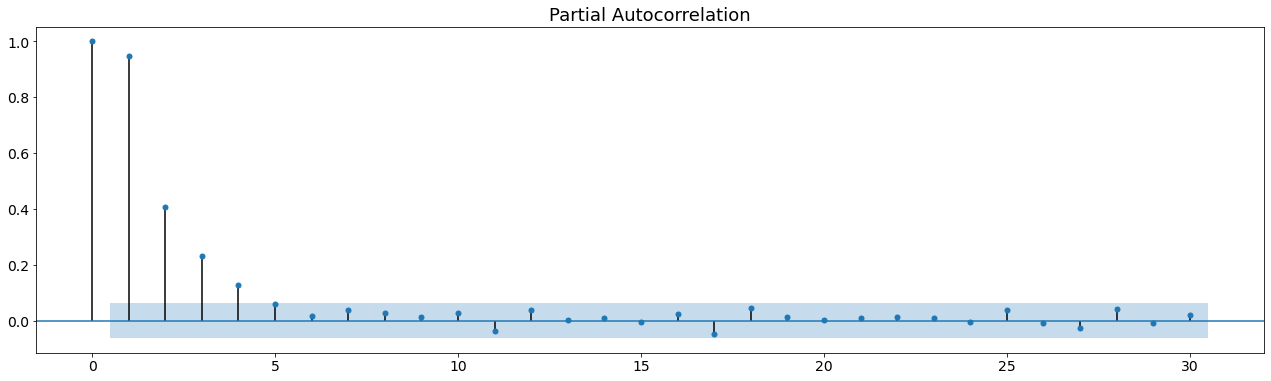

In [27]:
_ = tsa.plot_pacf(T+R)

Tendência decrescente + Ruído

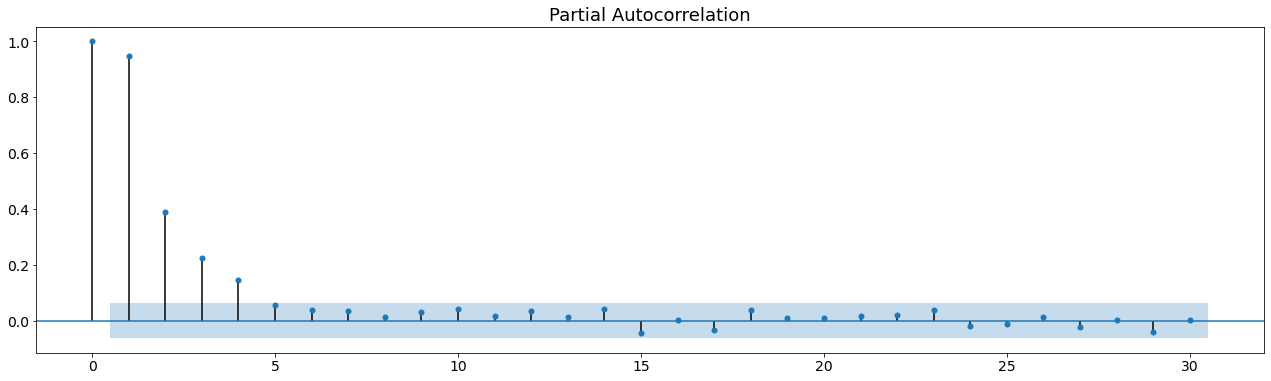

In [28]:
_ = tsa.plot_pacf(-T+R)

Apenas Ruído

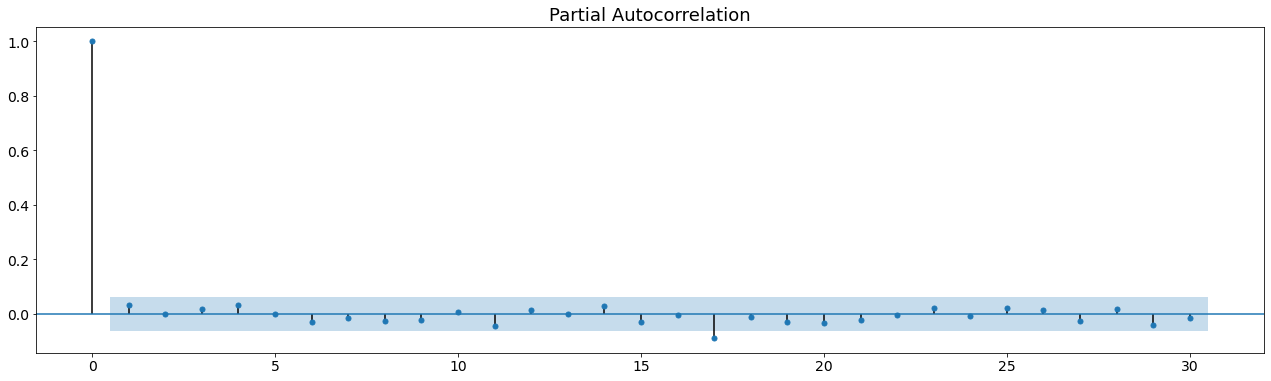

In [29]:
_ = tsa.plot_pacf(R)

Estacionária

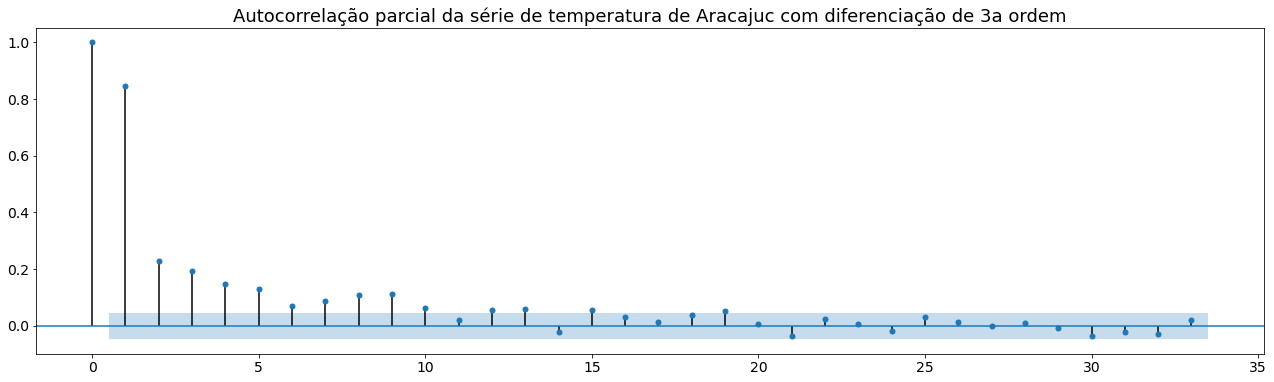

In [30]:
temp_diferenciada = serie_aracaju.tavg.diff(365).diff(30).diff().dropna()
_ = tsa.plot_pacf(serie_aracaju.tavg, title="Autocorrelação parcial da série de temperatura de Aracajuc com diferenciação de 3a ordem")

### Analisando a série de temperaturas

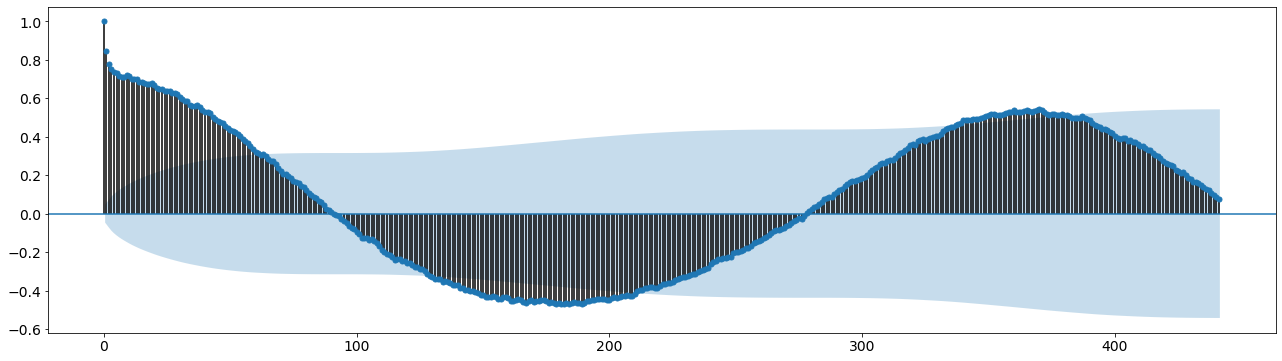

In [31]:
_ = tsa.plot_acf(serie_aracaju.tavg, lags= (serie_aracaju.shape[0] / 4), title="")

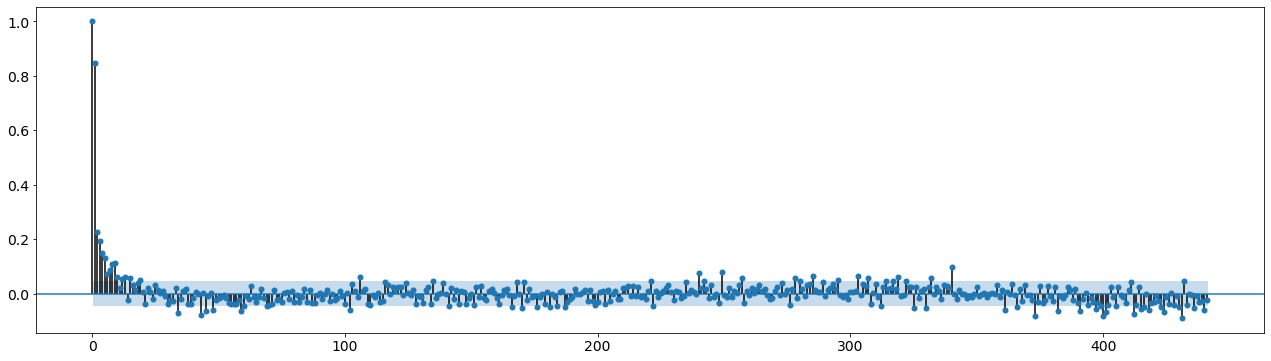

In [32]:
_ = tsa.plot_pacf(serie_aracaju.tavg, lags= (serie_aracaju.shape[0] / 4), title="")

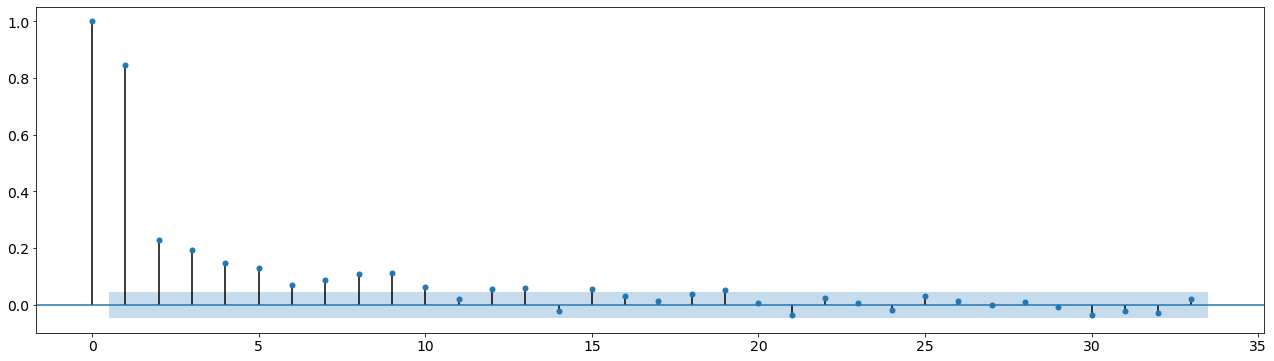

In [33]:
_ = tsa.plot_pacf(serie_aracaju.tavg, title="")

In [34]:
a = tsa.pacf(serie_aracaju.tavg, alpha = 0.05)

temp_pacf = pd.concat([pd.Series(a[0]).rename('pacf'), pd.DataFrame(a[1])],axis=1)
temp_pacf["intervalo"] = temp_pacf[1] - temp_pacf.pacf
temp_pacf["fora_intervalo"] = temp_pacf.apply(lambda x: True if x.pacf < -x.intervalo or x.pacf > x.intervalo else False, axis=1)
temp_pacf

,pacf,0,1,intervalo,fora_intervalo
0,1.000000,1.000000,1.000000,0.000000,True
1,0.845590,0.798937,0.892242,0.046653,True
2,0.227127,0.180474,0.273780,0.046653,True
3,0.192978,0.146325,0.239630,0.046653,True
4,0.148076,0.101423,0.194728,0.046653,True
5,0.130370,0.083717,0.177023,0.046653,True
6,0.070495,0.023843,0.117148,0.046653,True
7,0.087569,0.040917,0.134222,0.046653,True
8,0.109142,0.062490,0.155795,0.046653,True
9,0.111285,0.064632,0.157937,0.046653,True


Aplicando mais diferenciações

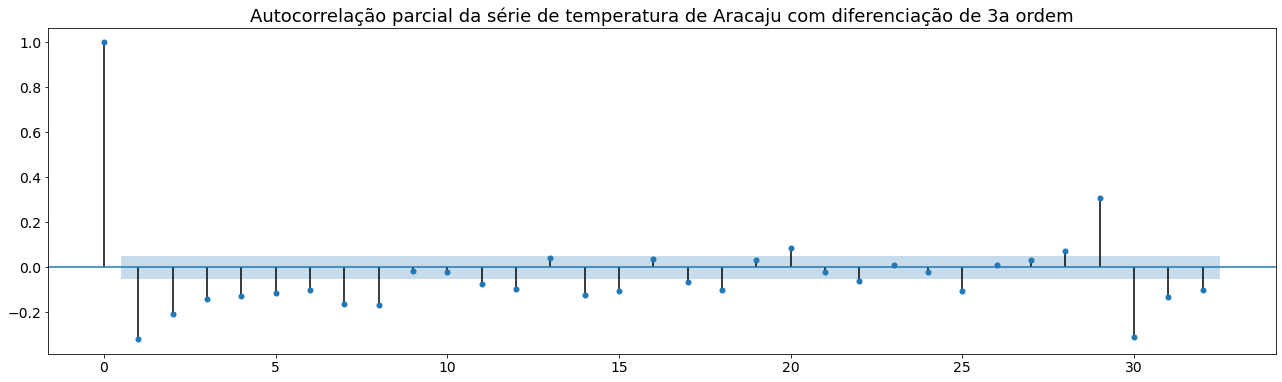

In [40]:
_ = tsa.plot_pacf(serie_aracaju.tavg.diff(365).diff(30).diff().dropna(),
                  title="Autocorrelação parcial da série de temperatura de Aracaju com diferenciação de 3a ordem")

In [36]:
a1 = tsa.pacf(serie_aracaju.tavg.diff(365).diff(30).diff().dropna(), alpha = 0.05)

temp_pacf_diff = pd.concat([pd.Series(a[0]).rename('pacf'), pd.DataFrame(a[1])],axis=1)
temp_pacf_diff["intervalo"] = temp_pacf_diff[1] - temp_pacf_diff.pacf
temp_pacf_diff["fora_intervalo"] = temp_pacf_diff.apply(lambda x: True if x.pacf < -x.intervalo or x.pacf > x.intervalo else False, axis=1)
temp_pacf_diff

,pacf,0,1,intervalo,fora_intervalo
0,1.000000,1.000000,1.000000,0.000000,True
1,0.845590,0.798937,0.892242,0.046653,True
2,0.227127,0.180474,0.273780,0.046653,True
3,0.192978,0.146325,0.239630,0.046653,True
4,0.148076,0.101423,0.194728,0.046653,True
5,0.130370,0.083717,0.177023,0.046653,True
6,0.070495,0.023843,0.117148,0.046653,True
7,0.087569,0.040917,0.134222,0.046653,True
8,0.109142,0.062490,0.155795,0.046653,True
9,0.111285,0.064632,0.157937,0.046653,True


## Exercício

1. Construa a visualização da autocorrelação e a autocorrelação parcial da série de temperatura média da sua cidade.
2. Construa a visualização da autocorrelação e a autocorrelação parcial das séries de câmbio dólar/real, euro/real e dólar/yuan chinês.
3. Construa a visualização da autocorrelação e a autocorrelação parcial das séries de inflação (IPCA) e IGP-M.
4. Para todas as séries anteriores, realize o teste de Ljung-box antes e depois de diferenciações para remover tendência e sazonaidade.
5. Para todas as autocorrelações calculadas, calcule também o efeito de compensação.